In [1]:
import numpy as np
import MDAnalysis as mda

# Load the trajectory and topology files
u = mda.Universe('v+centerilk.pdb', 'v+center.xtc')

# Define the atom selection for center of mass calculation
atom_numbers = [1670, 3607, 6537, 8474]
atoms = u.atoms[atom_numbers]

# Define the dimensions of the cylinder
radius = 8  # in angstrom
height = 40  # in angstrom
cylinder_center_offset = -10  # in angstrom

# Define the atom selection for cylinder occupancy analysis
popc_selection = 'resname POPC* and name O14 O33 N4 C36 C38 C40 C42 C44 C46 C48 C50 C18 C20 C22 C24 C26 C28 C30 P8 and (index 9735 to 25074)'
popc_atoms = u.select_atoms(popc_selection)

# Calculate center of mass for each frame
center_of_mass = []
inside_atoms = set()
cylinder_center_z = []  # Store the z-coordinate of the cylinder center

for ts in u.trajectory[::10]:
    # Calculate center of mass for the selected atoms
    com = atoms.center_of_mass()
    center_of_mass.append(com)

    # Calculate the center of the cylinder based on the center of mass
    cylinder_center = com - np.array([0, 0, cylinder_center_offset])
    
    # Store the z-coordinate of the cylinder center
    cylinder_center_z.append(cylinder_center[2])


    # Check if POPC atoms are inside the cylinder
    for atom in popc_atoms:
        atom_pos = atom.position
        dist_xy = np.linalg.norm(atom_pos[:2] - cylinder_center[:2])  # Distance in the xy-plane
        dist_z = abs(atom_pos[2] - cylinder_center[2])  # Distance along the z-axis

        if dist_xy <= radius and dist_z <= height / 2:
            inside_atoms.add(atom.index)


# Get the names of the atoms in atom_numbers
atom_names = [u.atoms[atom_id].name for atom_id in atom_numbers]

# Write z-coordinate results to "xxx.xvg" file
with open('xxx5_residuecount.xvg', 'w') as f:
    # Write the header with column names
    f.write("Time Center ")
    for atom_id in inside_atoms:
        atom = u.atoms[atom_id]
        f.write(f"{atom.name}_{atom.resid} ")
    f.write("\n")

    for ts, com, cylinder_z in zip(u.trajectory[::10], center_of_mass, cylinder_center_z):
        # Calculate the center of the cylinder based on the center of mass
        cylinder_center = com - np.array([0, 0, cylinder_center_offset])

        # Write the time in the first column
        f.write(f"{ts.time} {cylinder_z:.2f} ")

        # Check if POPC atoms are inside the cylinder
        for atom_id in inside_atoms:
            atom = u.atoms[atom_id]
            atom_pos = atom.position
            dist_xy = np.linalg.norm(atom_pos[:2] - cylinder_center[:2])  # Distance in the xy-plane
            dist_z = abs(atom_pos[2] - cylinder_center[2])  # Distance along the z-axis

            if dist_xy <= radius and dist_z <= height / 2:
                # Write the z-coordinate of the atom if it is inside the cylinder
                f.write(f"{100 + atom_pos[2] - cylinder_z:.2f} ")
            else:
                # Write 0.00 if the atom is outside the cylinder
                f.write("0.00 ")

        f.write("\n")

# Print the atom IDs, names, and residue numbers of POPC atoms that were inside the cylinder during the trajectory
print("Atom IDs, names, and residue numbers of POPC atoms inside the cylinder:")
for atom_id in inside_atoms:
    atom = u.atoms[atom_id]
    residue = atom.resid
    print(f"ID: {atom_id}  Name: {atom.name}  Residue: {residue}")


/home/user1/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/user1/anaconda3/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


Atom IDs, names, and residue numbers of POPC atoms inside the cylinder:
ID: 18759  Name: C30  Residue: 462
ID: 15663  Name: N4  Residue: 403
ID: 18737  Name: P8  Residue: 462
ID: 18967  Name: C30  Residue: 466
ID: 18749  Name: C20  Residue: 462
ID: 18747  Name: C18  Residue: 462
ID: 18781  Name: C50  Residue: 462


In [2]:
# Define the input and output file names
input_file = 'xxx5_residuecount.xvg'
output_file = 'xxx5_residuecount_modified.xvg'

# Read the input file, skip the second column, and write the modified content to the output file
with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
    for line in infile:
        # Split the line into columns
        columns = line.split()
        # Skip the second column and write the remaining columns to the output file
        outfile.write(columns[0] + " " + " ".join(columns[2:]) + "\n")

print("Second column removed. Modified file saved as:", output_file)


Second column removed. Modified file saved as: xxx5_residuecount_modified.xvg


Extracted residue numbers: ['462', '403', '462', '466', '462', '462', '462']


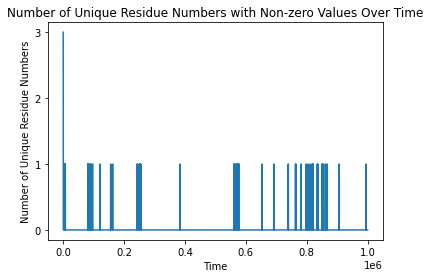

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Read the file to extract residue names from the header
with open('xxx5_residuecount_modified.xvg', 'r') as file:
    first_line = file.readline().split()[1:]  # Assuming the header is in the first line
    residue_names = [name.strip() for name in first_line if name.strip() != 'Time']

# Extract residue numbers from residue names
residue_numbers = [name.split('_')[-1] for name in residue_names]

print("Extracted residue numbers:", residue_numbers)

# Read data from the file
data = np.genfromtxt('xxx5_residuecount_modified.xvg', skip_header=1)  # Skip the first line

# Extract time and residue data
time = data[:, 0]
residue_data = data[:, 1:]  # Exclude the second column

# Find unique residue numbers with non-zero values for each time frame
unique_counts = []
for frame in residue_data:
    non_zero_residues = [residue_numbers[i] for i, val in enumerate(frame) if val != 0.0]
    unique_counts.append(len(set(non_zero_residues)))

# Plot the results
plt.plot(time, unique_counts)
plt.xlabel('Time')
plt.ylabel('Number of Unique Residue Numbers')
plt.title('Number of Unique Residue Numbers with Non-zero Values Over Time')

# Remove grid
plt.grid(False)

# Set y-axis ticks to integers
plt.yticks(range(max(unique_counts) + 1))

plt.savefig('unique_residue_numbers_over_time.pdf')

plt.show()
